<a href="https://colab.research.google.com/github/vitroid/boo/blob/main/boo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

局所構造の指標としてよく使われるQ(あるいはq)について考察します。

Qは球面調和関数を使って定義される指標です。

$$ 式だれか書いて $$

## 球面調和関数

球面調和関数は、球面上に立つ波の形に関する基底です。

「基底」、特に正規直交基底は、次のような条件を満たす関数群$b_n(x)$です。
* 任意の関数$f(x)$が、基底の線形結合で表せる。(係数を$a_n$とする)
$$ f(x) = \sum_n a_n b_n(x) $$
* 異なる基底同士を積分すると0 (直交性)
$$ \int_x b_m(x)b_n(x) \mathrm d x=0 $$
* 同じ基底の絶対値は1 (正規性)
$$ \int_x b_m(x)b_m(x) \mathrm d x=1 $$

最も身近な基底として、フーリエ基底があります。1次元の箱の中の波動関数は、n=1,2,3,4,...の正弦波で書ける、というあれです。

球面調和関数の場合、球面上の関数なので、$x$に相当するものは、極座標系における2つの角$(\theta, \phi)$です。また、量子数も2つあります。

球面調和関数は、水素原子の波動関数の式のなかにすでに出てきているので、見たことがあるはずです。



モルワイデ図法の座標変換については別紙。
https://colab.research.google.com/drive/1XAcSpD2fKkiu3o69CJ93okSR_-Rput3A?usp=sharing

経度緯度と、極座標では緯度(縦方法)の表しかたが違うことに注意。経度緯度では緯度0は赤道だが、極座標では$\theta=0$は北極を表す。

In [ ]:
import numpy as np


def equirectangular_grid(width=1000):
    height = width // 2

    x = np.linspace(-np.pi, +np.pi, width)
    y = np.linspace(-np.pi/2, +np.pi/2, height)

    return np.meshgrid(x, y)


def mollweide_grid(width=1000):
    """
    モルワイデ図のピクセル(x,y)に射影される、球面上の経度alphaと緯度deltaを返す。

    alpha, deltaいずれも、1000x500の二次元array.
    図の外側ではalpha=NaN.
    """
    X, Y = equirectangular_grid(width)

    theta = np.arcsin(2*Y/np.pi)
    alpha = X / ((1-(2*Y/np.pi)**2)**0.5)
    alpha[alpha<-np.pi] = np.nan
    alpha[alpha>np.pi] = np.nan
    delta = np.arcsin((2*theta+np.sin(2*theta)) / np.pi)

    return alpha, delta


`scipy.special.sph_harm`関数は引数の順番がキモい。
$Y_l^m(\theta, \phi)$==`sph_harm(m, l, phi, theta)`

<ipython-input-1-3eb1ef061047>:18: RuntimeWarning: divide by zero encountered in true_divide
  alpha = X / ((1-(2*Y/np.pi)**2)**0.5)


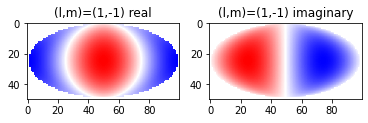

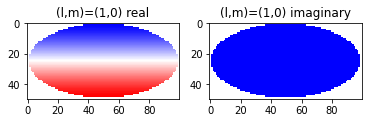

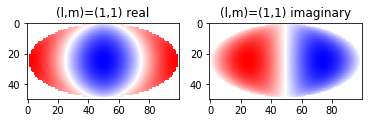

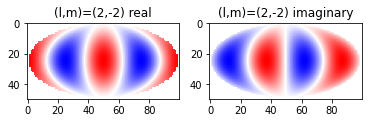

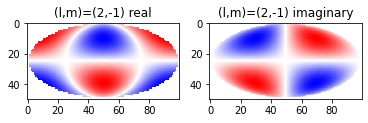

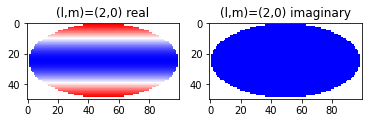

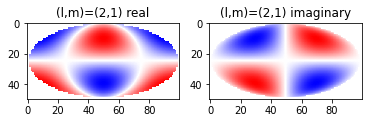

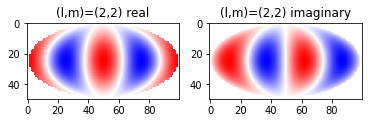

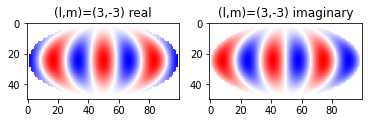

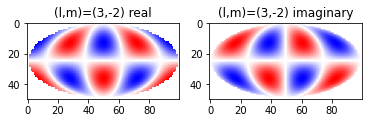

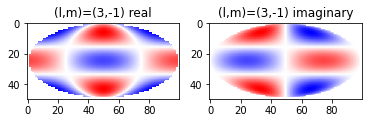

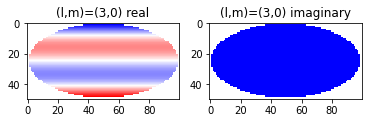

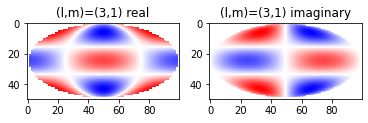

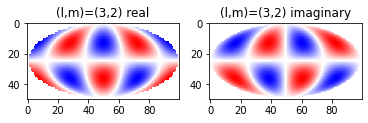

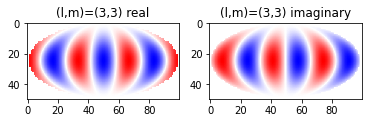

In [ ]:
import scipy.special
import matplotlib.pyplot as plt

keido, ido = mollweide_grid(width=100)
# 緯度と極座標のthetaでは角度のとりかたが違う。
theta = np.pi/2 - ido

for l in range(1,4):           # 主量子数
    for m in range(-l, l+1):   # 副量子数
        # sph_harm関数は、経度緯度をarrayで渡せば、まとめて計算してくれる(numpy-ish)
        Y = scipy.special.sph_harm(m, l, keido, theta, out=None)

        # 2次元配列なので画像として表示する
        fig, axs = plt.subplots(1,2)
        sc = axs[0].imshow(Y.real, cmap='bwr')
        sc = axs[1].imshow(Y.imag, cmap='bwr')
        axs[0].set_title(f"(l,m)=({l},{m}) real")
        axs[1].set_title(f"(l,m)=({l},{m}) imaginary")
        # axs[1].colorbar(sc)
        plt.show()

実際に、球面調和関数が正規直交基底であることを数値積分で確かめてみよう。

球面関数$f(\theta, \phi)$の球面積分は次のように書ける。
$$I=\int_0^\pi\int_0^{2\pi}f(\theta,\phi)\sin\theta\mathrm d\phi\mathrm d\theta$$
$Y_l^n$と$Y_{l'}^{n'}$が直交しているかどうかを確認しよう。

In [ ]:
def spherical_integ(f, theta, dtheta, dphi):
    """
    theta, phiは極方向、赤道方向の等間隔tick
    fはshapeが(theta, phi)の配列
    """
    integrand = f * np.sin(theta)[:, np.newaxis]
    return np.sum(integrand) * dtheta * dphi

# 角度目盛を作る
theta_tick = np.linspace(0, np.pi, 1001)
phi_tick = np.linspace(-np.pi, np.pi, 2001)
# 目盛の間隔
dtheta = np.pi / 1000
dphi= 2*np.pi / 2000
# meshgridにする = 2次元の配列に展開される。
phi, theta = np.meshgrid(phi_tick, theta_tick)

# 先に球面調和関数を計算しておく。
Y = dict()
for l in range(3):
    for m in range(-l, +l+1):
        Y[l, m] = scipy.special.sph_harm(m, l, phi, theta, out=None)

I = np.zeros([len(Y), len(Y)])
for i, (q1, f1) in enumerate(Y.items()):
    for j, (q2, f2) in enumerate(Y.items()):
        # 複素関数なので、共役複素数をかけて積分する。
        # 雑な数値積分なので、ぴったりとは合わない。
        I[i,j] = spherical_integ(f1*f2.conj(), theta_tick, dtheta, dphi).round(2)
        # 量子数と交差積分
        # if I[i,j] > 0.5:
        print(q1,q2,I[i,j])


<ipython-input-4-3c4744bba5cc>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  I[i,j] = spherical_integ(f1*f2.conj(), theta_tick, dtheta, dphi).round(2)


(0, 0) (0, 0) 1.0
(0, 0) (1, -1) -0.0
(0, 0) (1, 0) 0.0
(0, 0) (1, 1) 0.0
(0, 0) (2, -2) 0.0
(0, 0) (2, -1) 0.0
(0, 0) (2, 0) -0.0
(0, 0) (2, 1) 0.0
(0, 0) (2, 2) 0.0
(1, -1) (0, 0) -0.0
(1, -1) (1, -1) 1.0
(1, -1) (1, 0) -0.0
(1, -1) (1, 1) -0.0
(1, -1) (2, -2) -0.0
(1, -1) (2, -1) -0.0
(1, -1) (2, 0) 0.0
(1, -1) (2, 1) 0.0
(1, -1) (2, 2) -0.0
(1, 0) (0, 0) 0.0
(1, 0) (1, -1) -0.0
(1, 0) (1, 0) 1.0
(1, 0) (1, 1) 0.0
(1, 0) (2, -2) -0.0
(1, 0) (2, -1) -0.0
(1, 0) (2, 0) 0.0
(1, 0) (2, 1) 0.0
(1, 0) (2, 2) 0.0
(1, 1) (0, 0) 0.0
(1, 1) (1, -1) -0.0
(1, 1) (1, 0) 0.0
(1, 1) (1, 1) 1.0
(1, 1) (2, -2) 0.0
(1, 1) (2, -1) 0.0
(1, 1) (2, 0) -0.0
(1, 1) (2, 1) -0.0
(1, 1) (2, 2) 0.0
(2, -2) (0, 0) 0.0
(2, -2) (1, -1) -0.0
(2, -2) (1, 0) -0.0
(2, -2) (1, 1) 0.0
(2, -2) (2, -2) 1.0
(2, -2) (2, -1) -0.0
(2, -2) (2, 0) -0.0
(2, -2) (2, 1) -0.0
(2, -2) (2, 2) 0.0
(2, -1) (0, 0) 0.0
(2, -1) (1, -1) -0.0
(2, -1) (1, 0) -0.0
(2, -1) (1, 1) 0.0
(2, -1) (2, -2) -0.0
(2, -1) (2, -1) 1.0
(2, -1) (2, 0) -0.

フーリエ変換と同じように、任意の球面関数を、基底の線形和に分解できるのかどうかも知りたい。

例として、Y(1,0)を$\theta$方向に45度傾けた関数を作ってみる。

$(\theta, \phi)$で表される、半径1の球面上の点の点のユークリッド座標は$$(x,y,z)=(\sin\theta\cos\phi, \sin\theta\sin\phi, \cos\theta)$$
ユークリッド座標から極座標への逆変換は?
$$x^2+y^2=\sin^2\theta$$
$$z^2=\cos^2\theta$$
$$\theta=\arctan{\sqrt{x^2+y^2}\over z}$$
$$\phi=\arctan{y\over x}$$

これを$y$軸に関して45度回転させると?
$$(x',z')=(x\cos 45-z\sin 45, x\sin 45+z\cos 45)={1\over \sqrt 2}(x-z, x+z)$$
回転後の球面上の点のユークリッド座標は
$$(x',y',z')={1\over \sqrt 2}(\sin\theta\cos\phi-\cos\theta, \sqrt{2} \sin\theta\sin\phi, \sin\theta\cos\phi+\cos\theta)$$



<ipython-input-2-3eb1ef061047>:18: RuntimeWarning: divide by zero encountered in true_divide
  alpha = X / ((1-(2*Y/np.pi)**2)**0.5)


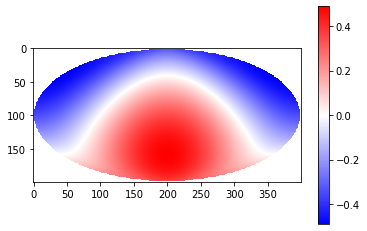

In [ ]:
import scipy.special
import matplotlib.pyplot as plt

def euclid_to_euler(x,y,z):
    return np.arctan2((x**2+y**2)**0.5, z), np.arctan2(y, x)


def euler_to_euclid(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return np.array([x,y,z])


def rotate_y(theta, phi, angle):
    """
    極座標の点を、y軸回りに回転させ、回転後の点の極座標を返す。
    numpy compliant.
    """
    x,y,z = euler_to_euclid(theta, phi)

    xp = ( x*np.cos(angle) - z*np.sin(angle) )
    yp = y
    zp = ( x*np.sin(angle) + z*np.cos(angle) )

    return euclid_to_euler(xp,yp,zp)


phi, ido = mollweide_grid(width=400)
theta = np.pi/2 - ido

thetap, phip = rotate_y(theta, phi, np.pi/4)

f = scipy.special.sph_harm(0, 1, phip, thetap, out=None).real
sc = plt.imshow(f, cmap='bwr')
plt.colorbar(sc)
plt.show()

この球面関数を、球面調和基底で変換する(線形結合の係数を求める)。


In [ ]:
def spherical_integ(f, theta, dtheta, dphi):
    """
    theta, phiは極方向、赤道方向の等間隔tick
    fはshapeが(theta, phi)の配列
    """
    integrand = f * np.sin(theta)[:, np.newaxis]
    return np.sum(integrand) * dtheta * dphi

# 角度目盛を作る
theta_tick = np.linspace(0, np.pi, 1001)
phi_tick = np.linspace(-np.pi, np.pi, 2001)
# 目盛の間隔
dtheta = np.pi / 1000
dphi= 2*np.pi / 2000
# meshgridにする
phi, theta = np.meshgrid(phi_tick, theta_tick)

thetap, phip = rotate_y(theta, phi, np.pi/4)

f = scipy.special.sph_harm(0, 1, phip, thetap, out=None).real

# 先に球面調和関数を計算しておく。
Y = dict()
for l in range(3):
    for m in range(-l, +l+1):
        Y[l, m] = scipy.special.sph_harm(m, l, phi, theta, out=None)

I = np.zeros([len(Y), len(Y)])
for i, (q1, f1) in enumerate(Y.items()):
    # 複素関数なので、共役複素数をかけて積分する。
    # 雑な数値積分なので、ぴったりとは合わない。
    I = spherical_integ(f1*f.conj(), theta_tick, dtheta, dphi).round(3)
    # 量子数と交差積分
    # if I[i,j] > 0.5:
    print(q1,I)


(0, 0) (-0+0j)
(1, -1) (0.501+0j)
(1, 0) (0.707+0j)
(1, 1) (-0.501+0j)
(2, -2) (-0+0j)
(2, -1) (-0+0j)
(2, 0) 0j
(2, 1) -0j
(2, 2) (-0+0j)


非0成分は$(l, m)=(1,\{-1,0,1\})$のみ。これらを線形結合して、プロットしてみよう。


<ipython-input-2-3eb1ef061047>:18: RuntimeWarning: divide by zero encountered in true_divide
  alpha = X / ((1-(2*Y/np.pi)**2)**0.5)


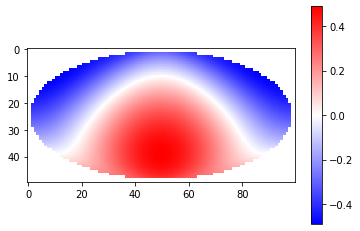

In [ ]:
import scipy.special
import matplotlib.pyplot as plt

keido, ido = mollweide_grid(width=100)
theta = np.pi/2 - ido

f = scipy.special.sph_harm(-1, 1, keido, theta, out=None)/2
f += scipy.special.sph_harm(0, 1, keido, theta, out=None)/2**0.5
f += scipy.special.sph_harm(+1, 1, keido, theta, out=None)/(-2)

sc = plt.imshow(f.real, cmap='bwr')
plt.colorbar(sc)
plt.show()

ナイス! これでわかったのは、
* 球面調和関数は確かに基底を張っている。任意の球面関数は、球面調和関数の和で表せそうだ。
* ここで作った球面関数は、$l=1$の球面調和関数の実数部分を45度回したものだった。これは、$l=1$の球面調和関数の線形結合であらわせ、より高次の球面調和関数は必要としなかった。この点もフーリエ変換によく似ている。
* 線形結合の係数から、元の関数が、球面調和関数のどれをどちらむきに傾けたものかを推定できるはずだ。(これ重要)
* 実数の球面関数を展開した場合、重みも実数になる。

## 結合配向秩序

球面調和関数が一次元における正弦関数に似ていることがだいたいわかったので、次に結合配向秩序を検討する。

結晶は、原子がある秩序に従って整列したものである。結晶のなかでは、隣接する原子は結合していて、その結合ベクトルの方向は特定の方向に向いている。例えば、体心立方格子であれば、4方向(逆向きを含めれば8方向)の結合ベクトルがあり、互いに70.5度の角をなしている。この結合ベクトルの向きを球面上に射影すると、8つの点が生じる。(余談だが、Gyroid構造に出現するねじれ角も70.5度。幾何学的に関連しているはず。)

熱揺らぎがあると、結合ベクトルの方向もゆらぎ、球面上の射影は8個の点から8個の分布となる。この球面関数を球面調和関数展開すれば、配向に関する特徴量(各基底の重み)を得ることができる。

結晶は、常に空間座標(シミュレーションセルの辺方向)に沿った方向に生じるとは限らない。結晶が傾いていると、特徴量も変化するので、基底の重みだけを見比べると、別の構造に見えてしまう。

そこで、結晶が傾いていても、同じ数値が得られるように、うまく基底の重みを組みあわせる。これが結合配向秩序指標である。ちょうど、フーリエ変換において、位相のずれを無視するために、パワースペクトルに変換することに対応する。(パワースペクトルは各振動数でのsin成分とcos成分の二乗和で計算される。)

現実には、系全体が単結晶になることは稀であり、結合配向秩序も場所ごとに別々に計算することが多い。(場所ごとに計算する場合は、部分空間を切りとり、その中にある結合の方向のみで結合配向秩序を計算する)

多結晶で、いろんな向きの結晶粒が生じていたとしても、それらが同じ結晶構造をもっていれば、場所ごとの結合配向秩序の値は同一となる。



まず、方向が$(\theta, \phi)$ボンド1本に対して、次の量を計算する。
$$q=Y_l^m(\theta, \phi)$$
これは、実際には以下の畳み込み積分と同じ意味なので、球面上のデルタ関数を球面調和関数展開しているとみなせる。
$$q=\iint\delta(\theta-\theta', \phi-\phi')Y_l^m(\theta', \phi')\sin\theta'\mathrm d\theta\mathrm d\phi$$
結合は複数あるが、独立なので、単純に足しあわせればいい。
$$q_{lm}(i)={1\over N}\sum_{j\ne i}^NY_l^m\left(\theta_{ij}, \phi_{ij}\right)$$
これが、ある原子$i$と、周囲の原子$j$の間の結合の球面調和関数展開であり、
異なる$(l,m)$に対して異なる「重み」(スカラ量)が得られる。

結合配向秩序指数$q_l(i)$はこれを用いて次のように定義される。
$$q_l(i)=\sqrt{{4\pi\over 2l+1}\sum_{m=-l}^{l}\left|q_{lm}(i)\right|^2}$$
これは、球面調和関数展開した係数の二乗和をとり、規格化したものにすぎない。

いくつかのよくある局所構造に対して、結合配向秩序を計算しておこう。

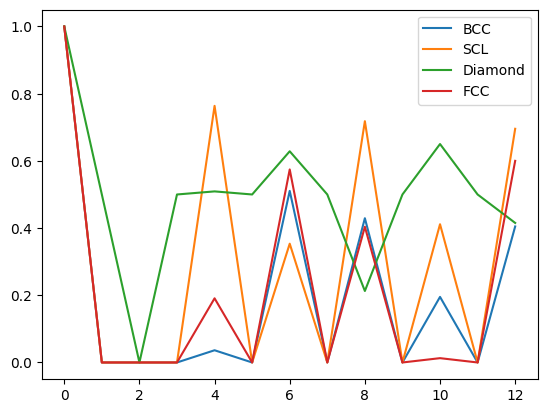

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def euclid_to_euler(x,y,z):
    return np.arctan2((x**2+y**2)**0.5, z), np.arctan2(y, x)


def qlm(l,m,x,y,z):
    """
    球面ベクトルの球面調和関数展開
    """
    theta, phi = euclid_to_euler(x,y,z)
    # print(theta,phi)
    return scipy.special.sph_harm(m, l, phi, theta, out=None).mean()


def boo(l, x,y,z):
    """
    結合配向秩序指標
    """
    s = 0
    for m in range(-l, l+1):
        q = qlm(l,m, x,y,z)
        s += q * q.conj()
    return (s*4*np.pi/(2*l+1))**0.5

# 単純立方格子。隣接ベクトルは6本。
scl = np.array([[-1.0, 0.0, 0.0],
                 [0.0, -1.0, 0.0],
                 [0.0, 0.0, -1.0],
                 [1.0, 0.0, 0.0],
                 [0.0, 1.0, 0.0],
                 [0.0, 0.0, 1.0]
                 ])
# 体心立方格子
bcc = np.array([[-1,-1,-1],
                [-1,-1,+1],
                [-1,+1,-1],
                [-1,+1,+1],
                [+1,-1,-1],
                [+1,-1,+1],
                [+1,+1,-1],
                [+1,+1,+1],
                # Steinhardtとあわせるために、第二隣接までとる。
                [-2.0, 0.0, 0.0],
                 [0.0, -2.0, 0.0],
                 [0.0, 0.0, -2.0],
                 [2.0, 0.0, 0.0],
                 [0.0, 2.0, 0.0],
                 [0.0, 0.0, 2.0]
                ]) / 3**0.5
# ダイヤモンド格子
dia = np.array([[-1,-1,-1],
                [+1,-1,-1],
                [+1,-1,+1],
                [+1,+1,-1]]) / 3**0.5
# 面心立方格子
fcc = np.array([[-1,-1,0],
                [-1,+1,0],
                [+1,-1,0],
                [+1,+1,0],
                [-1,0,-1],
                [-1,0,+1],
                [+1,0,-1],
                [+1,0,+1],
                [0,-1,-1],
                [0,-1,+1],
                [0,+1,-1],
                [0,+1,+1]]) / 2**0.5


samples = {"BCC": bcc, "SCL": scl, "Diamond": dia, "FCC": fcc}
for label, vectors in samples.items():
    x,y,z = vectors.T

    Y = []
    for l in range(13):
        Y.append(boo(l,x,y,z))

    Y = np.array(Y)

    plt.plot(Y.real, label=label)


plt.legend()



(2023-10-03 [Steinhardt論文](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.28.784)でチェック済み)

よく使われる$q_6$は、どの結晶構造でも大きな値になるので、秩序化しているかどうかの目安にはよさそうだ。

結晶構造を見わけたい場合は、複数の特徴量をあわせるのが良い。BCCとダイヤモンドは、実質的には識別不可能に思える。(反対向きベクトルも含めると全く同じ方向にベクトルが向いている)


座標系を回転させても$q_l$の値が変化しないことを確認しておく。

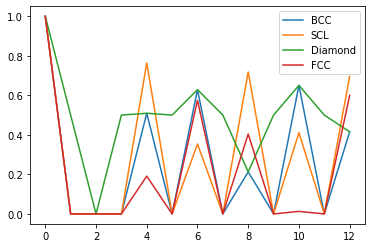

In [ ]:
# 回転行列を自分で書くのが面倒なので、scipyを流用する。
from scipy.spatial.transform import Rotation

# ランダム回転行列
R = Rotation.from_rotvec(np.random.random(3)).as_matrix()

samples = {"BCC": bcc, "SCL": scl, "Diamond": dia, "FCC": fcc}
for label, vectors in samples.items():
    x,y,z = (vectors@R).T

    Y = []
    for l in range(13):
        Y.append(boo(l,x,y,z))

    Y = np.array(Y)

    plt.plot(Y.real, label=label)

plt.legend()


問題ない!

## 結合配向秩序の先へ

* 結合配向秩序が傾きの情報を捨てていることを再検討する。
  * 結合配向秩序ではなく、あえて基底の重みを直接調べることで、結晶粒がどの方向に傾いているかを読みとれるはずだ。位相に注目するのである。
    * 球面調和関数に回転行列をかけたものは何になるのか。

  * 例えば氷であれば、隣接分子との4本の結合だけで結合配向秩序を計算すると、いつもだいたい同じような値になる。これは短距離秩序と呼ばれる。氷の結晶構造の違いは、もっと遠方の結合のつながり方で見分けなければならない。これは中距離秩序と言われている。第二隣接まで含めた、中距離空間をきりとって結合配向秩序を計算するのが安直な方法だが、それでいいのか?それよりも、中心分子と第一隣接で計算される球面関数と、第一隣接分子周囲の球面関数の間の「傾き」を捉えられないか?
* 一般には、メタンや水のような、四面体型やBCC型を好む構造にフィットするのは、$Y_{3m)$のはず。なぜ$Y_{6m}$系の$q_6$がもてはやされるのか。
  * $(Y_{3,1},Y_{3,2},Y_{3,3})$は四面体型分子の傾きを捉える良い指標ではないか?
* ダイヤモンド構造とBCCを区別する方法はないのか?
  * 第一隣接との結合のQ、第一と第二隣接の間の結合のQのほかに、前者と後者の交差項を考える?

## メタン分子の配向を一般的に表現する

メタンは4本の等価なCH結合を持ち対称数が12もある。オイラー角で分子の配向を表現しても、同じ向きかどうかを判断するのは難しい。

そこで、4本の結合の方向を球面調和展開し、その係数で分子の向きを表現することにする。

上に書いたように、$l=3$は正四面体分子に適した、4山4谷分布をもっているので、これでメタンの配向を展開してみる。



In [ ]:
import scipy.special


def euclid_to_euler(x,y,z):
    return np.arctan2((x**2+y**2)**0.5, z), np.arctan2(y, x)


def qlm(l,m,x,y,z):
    """
    球面ベクトルの球面調和関数展開
    """
    theta, phi = euclid_to_euler(x,y,z)
    # print(theta,phi)
    return scipy.special.sph_harm(m, l, phi, theta, out=None).mean()


# ダイヤモンド格子
dia = np.array([[-1,-1,-1],
                [-1,+1,+1],
                [+1,-1,+1],
                [+1,+1,-1]]) / 3**0.5

ax = np.radians(0)
ay = np.radians(0)
az = np.radians(90)

rot_x = np.array([[1.0, 0.0, 0.0],
                  [0.0, np.cos(ax), np.sin(ax)],
                  [0.0,-np.sin(ax), np.cos(ax)]])
rot_y = np.array([[np.cos(ay), 0.0,-np.sin(ay)],
                  [0.0, 1.0, 0.0],
                  [np.sin(ay), 0.0, np.cos(ay)]])
rot_z = np.array([[np.cos(az), np.sin(az), 0.0],
                  [-np.sin(az), np.cos(az), 0.0],
                  [0.0, 0.0, 1.0]])

dia = dia @ rot_x @ rot_y @ rot_z

coeffs = dict()
for l in (3,):
    for m in range(-l, +l+1):
        coeff = 0
        for v in dia:
            coeff += qlm(l, m, *v)
        print((l, m), coeff)
        coeffs[l, m] = coeff



(3, -3) (1.1102230246251565e-16+0j)
(3, -2) -1.573449573137716j
(3, -1) (2.7755575615628914e-17-1.3877787807814457e-17j)
(3, 0) 0j
(3, 1) (-5.551115123125783e-17+0j)
(3, 2) (-1.232595164407831e-32+1.5734495731377158j)
(3, 3) (-5.551115123125783e-17+0j)


<ipython-input-89-5755c0912238>:27: RuntimeWarning: divide by zero encountered in divide
  alpha = X / ((1-(2*Y/np.pi)**2)**0.5)


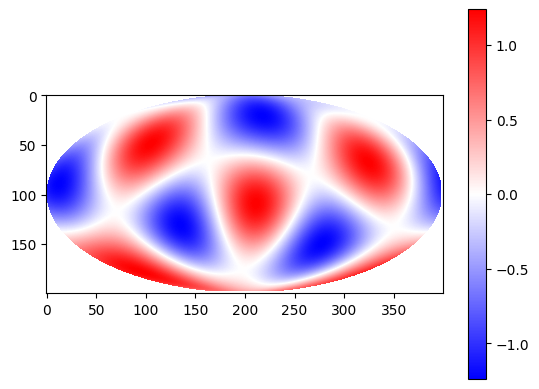

In [ ]:
# 係数をたしあわせる


import numpy as np
import matplotlib.pyplot as plt






phi, ido = mollweide_grid(width=400)
# phi, ido = equirectangular_grid(width=400)
theta = np.pi/2 - ido

f = 0
for l in (3,):
    for m in range(-l, +l+1):
        f += scipy.special.sph_harm(m, l, phi, theta, out=None) * coeffs[l, m]

sc = plt.imshow(f.real, cmap='bwr')
# sc = plt.imshow(np.abs(f), cmap='bwr')
plt.colorbar(sc)
plt.show()

実部に出現する数値は全部で4種類。実際には、オイラー角でも2変数で済むので、4つは過剰で、2次元に埋めこめるはずだが、数値の規則性がわからない。

## 実際のトラジェクトリで調査

以下はローカルに実行する前提で書く(Colabでは動かない)

In [17]:
from read_gro3 import read_gro

with open("/Users/matto/work/master_project/250K5000bar/300-last.gro") as f:
    for gro in read_gro(f):
        break

# cell matrix
cellmat = gro["cell"]

# inverse of the cell matrix
celli = np.linalg.inv(cellmat)

# pickup positions of carbon atoms, in the fractional coordinate
carbons = gro["position"][gro["atom"] == "C"] @ celli
carbons.shape

(10648, 3)

とりあえず、原子間距離をみつもる。短距離のRDFを作る。

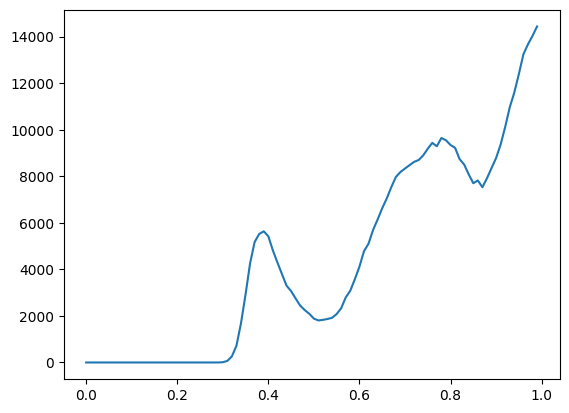

In [18]:
import pairlist as pl
import numpy as np
import matplotlib.pyplot as plt

# make the histogram of the distances of pairs within 1 nm.
H = np.histogram(
    [d for _, _, d in pl.pairs_iter(carbons, 1.0, cellmat)], range=(0, 1.0), bins=100
)
plt.plot(H[1][:-1], H[0])

第一隣接は0.5 nmぐらいまでか。

各原子について、0.5 nm以内にある隣接分子との相対座標ベクトルを作る。(規格化しておく)

In [28]:
import networkx as nx

# make the adjacency matrix within 0.5 nm
g = nx.Graph([(i, j) for i, j in pl.pairs_iter(carbons, 0.5, cellmat, distance=False)])

neighbors = dict()

for node in g:
    # vectors to the neighbor carbons
    vectors = carbons[g[node]] - carbons[node]

    # PBC treatment
    vectors -= np.floor(vectors + 0.5)

    # normalize (length is unity)
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]

    # and store.
    neighbors[node] = vectors

$q_{\{4,6,8,10,12\}}$を計算。

In [29]:
import boo

boos = np.zeros([carbons.shape[0], 5])

for node in g:
    for i, l in enumerate([4, 6, 8, 10, 12]):
        X = neighbors[node][:, 0]
        Y = neighbors[node][:, 1]
        Z = neighbors[node][:, 2]
        boos[node, i] = boo.boo(l, X, Y, Z)

boos

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_43950/1828062173.py:10: ComplexWarning:

Casting complex values to real discards the imaginary part



array([[0.40487892, 0.39669397, 0.40765898, 0.35117229, 0.30295317],
       [0.37617597, 0.55847836, 0.41567656, 0.35776994, 0.33958283],
       [0.38579909, 0.48531482, 0.38133868, 0.33329155, 0.31270088],
       ...,
       [0.38108897, 0.50856002, 0.44364999, 0.39431391, 0.41398636],
       [0.44023464, 0.33660764, 0.29246929, 0.29785798, 0.28591098],
       [0.38541105, 0.46877531, 0.35938473, 0.32503094, 0.32270944]])

とりあえず分解できそうか、q4,q6,q8で3次元散布図にしてみよう。

z座標によって構造が違うようなので、z座標の値で配色する。

In [34]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=boos[:, 0],
        y=boos[:, 1],
        z=boos[:, 2],
        mode="markers",
        marker=dict(size=2, color=carbons[:, 2]),
    )
)

fig.update_layout(
    title="q4,6,8",
    autosize=True,
    width=800,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
)

fig.show()

z座標の違いがbooの違いに対応している。ただし、クラスタリングするには分布の形があまりよろしくない。



### 並進ベクトルの抽出

並進して重なるような局所構造の対をさがし、それらをつなぐベクトルを列挙する。

過去にそのようなプログラムを書いた覚えがある。